In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import random
from IPython import display
%matplotlib inline
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

In [12]:
env = gym.make('FrozenLake-v0')

[2017-03-30 04:21:38,463] Making new env: FrozenLake-v0


In [13]:
env.reset()

0

In [16]:
env.observation_space.n

16

$$V = TV$$

In [41]:
def getP(C):
    P = C/np.sum(C,axis=2)[:,:,np.newaxis]
    return(P)

In [210]:
V = np.zeros(env.observation_space.n)
C = np.zeros([env.action_space.n,env.observation_space.n,env.observation_space.n])+0.01
R = np.zeros([env.action_space.n,env.observation_space.n,env.observation_space.n])

In [211]:
P =getP(C)

In [212]:
episodeMax = 1000
gamma = 0.99
rList = []
avgRList = []
weight = 0.85
flag = True

for episode in range(episodeMax):
    state = env.reset()
    done = False
    while not done:
        statePre = state
        P =getP(C)
        VconditionStatePre  =np.einsum('ij,ij->i',R[:,statePre,:],P[:,statePre,:])+gamma*np.dot(P[:,statePre,:],V)
        a = np.argmax(VconditionStatePre+np.random.randn(env.action_space.n)*(1/(1.0+episode)))
        state,reward,done,info =  env.step(a)
        R[a,statePre,state] =  R[a,statePre,state]*(1-weight) + reward*weight
        C[a,statePre,state] += 1
        V[statePre,] = V[statePre,]*(1-weight)+(weight)*(R[a,statePre,state]+np.dot(P[a,statePre,:],V)*gamma)
        
    if done:
        rList.append(reward)
    
    if episode >100:
                avgR = sum(rList[-100:])/100
                avgRList.append(avgR)
    if avgR>0.7 and flag:
        flag = False
        print(episode)
        
        

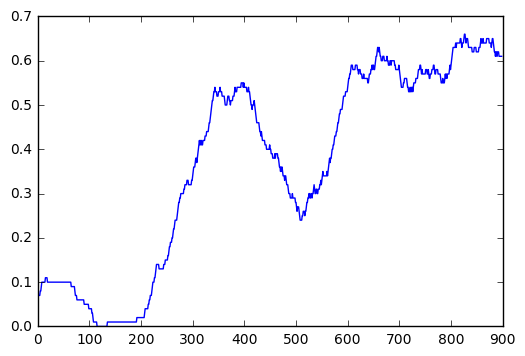

In [213]:
plt.plot(avgRList)